<a href="https://colab.research.google.com/github/ajinkyabhanudas/SIADS696/blob/dev/Modeling_phase1_Ajinkya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling
### (This notebook) Modeling Phase 1/2:
The focus of this notebook is on the following:
- Explore the potential usage of creating polynomial features for the entire/subset of the data.
- Incrementally tuning and choosing models, families based on improvement in results.

Note: This notebook would more than likely be to run out of RAM if it were run on colab and you'd need to run it part by part. Including the grid-search training (which has been commented to avoid accidental re-runs in places) the notebook would take about 10-11 hours to finish running.

In [3]:
!git clone https://github.com/ajinkyabhanudas/SIADS696.git
!pip install gensim==4.1.2

Cloning into 'SIADS696'...
remote: Enumerating objects: 584, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 584 (delta 18), reused 23 (delta 6), pack-reused 473
Receiving objects: 100% (584/584), 41.50 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Checking out files: 100% (164/164), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 62.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
import datetime
import enum
import glob
import json
import os
import re
from itertools import groupby

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from matplotlib import ticker

import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle

import warnings
warnings.simplefilter(action='ignore')

In [5]:
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score

from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

In [7]:
import gensim.downloader
glove_wv = gensim.downloader.load('glove-wiki-gigaword-50')

nltk.download('punkt')
nltk.download('stopwords')

[==================================================] 100.0% 66.0/66.0MB downloaded


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
try:
  os.chdir('SIADS696')
except:
  print("You're either already in the SIADS696 directory, or the path specified isn't accessible")

In [9]:
rootdir = 'data'
feature_list = ['publishedAt', 'title', 'channelId', 'description',
                'channelTitle', 'tags', 'categoryId', 'viewCount', 
                'likeCount', 'favoriteCount', 'commentCount', 'duration',
                'definition', 'contentRating', 'topicCategories', 'topicLabel']

ov_dict_list = []
ov_temp_dict = {}

dict_list = []
temp_dict = {}

for path in glob.glob(f'./{rootdir}/*/*'):
  try:
    with open(path, "r") as read_file:
      data = json.load(read_file)
    for channel_id in data.keys():
      ov_temp_dict = data[channel_id]["channel_statistics"]
      channel_name = list(data[channel_id]["video_data"].keys())[0]
      ov_temp_dict["channelName"] = data[channel_id]["video_data"][channel_name]["channelTitle"]
      ov_dict_list.append(ov_temp_dict)
      
      for video_info in data[channel_id]["video_data"].values():
        temp_dict = video_info
        temp_dict["topicLabel"] = path.split('/')[2]
        dict_list.append(temp_dict)       
  except:
    pass

overall_stats_raw_df = pd.DataFrame(ov_dict_list)
overall_stats_raw_df.drop("hiddenSubscriberCount", axis=1, inplace=True)

raw_df = pd.DataFrame(dict_list)
raw_df = raw_df[feature_list]

In [10]:
def make_poly(d=4):
  poly = PolynomialFeatures(d)
  trainX3 = poly.fit_transform(train_X[:,:3])
  trainX62 = train_X[:,3:]

  x_poly_train = np.concatenate((trainX62, trainX3), axis=1)

  testX3 = poly.transform(test_X[:,:3])
  testX62 = test_X[:,3:]

  x_poly_test = np.concatenate((testX62, testX3), axis=1)

  return(x_poly_train, x_poly_test)


In [11]:
def duration_split(duration):
    try:
      for _, v in groupby(duration, str.isalpha):
        yield ''.join(v)
    except:
      yield np.nan
    
def duration_2_secs(duration, duration_split=duration_split):
  temp = 0
  for i, val in enumerate(duration_split(duration)):
    
    if len(str(duration)) <= 8:
      if i==1 and not val.isalpha():
        temp += float(val)*60
      
      if i==3 and not val.isalpha():
        temp += float(val)
    else:
      if i==1 and not val.isalpha():
        temp += float(val)*60*60
      
      if i==3 and not val.isalpha():
        temp += float(val)*60
      
      if i==5 and not val.isalpha():
        temp += float(val)

  return(temp)


In [12]:
def topic_extract(links_list):
  
  topics_list = []  
  try:
    for link in links_list:
      topics_list.append(link.split("/")[-1].lower())
    
    return(topics_list)
  except:
    pass

In [13]:
def outlier_thresh(df, up=True):
  q1, q3 = np.percentile(df,[25,75])
  iqr = q3-q1
  if up:
    res = q3+1.5*iqr
  else:
    res = q1-1.5*iqr
  return(res)

In [14]:
def gen_word_vec(df_text_list, wordvec):
    word_vector = []
    for token in df_text_list:
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [i for i in token_considered if i in wordvec.key_to_index]
        if len(token_vocab) > 0:
            word_vector.append(np.mean(wordvec[token_vocab], axis=0))
        else:
            word_vector.append(np.zeros(wordvec.vector_size))
    word_vector = np.array(word_vector)
    try:
      return word_vector[0]
    except:
      return np.zeros(50)

In [15]:
def text_prep(val):
  '''the goal is to replace the hypertexts in the 
  in any field to redundant names as vectorizing
  them could be misleading and also leak data'''

  val = str(val).lower()
  process_desc = re.sub(r'http[s]*:.*\w', 'url', val)
  process_desc = re.sub('[^a-zA-Z]', ' ', process_desc)
  process_desc = re.sub(r'\s+', ' ', process_desc)

  process_desc = nltk.sent_tokenize(process_desc)
  if not process_desc:
    process_desc = [nltk.word_tokenize(word) for word in process_desc]
  else:
    process_desc = [nltk.word_tokenize(word) for word in process_desc][0]
    
  
  word_list = [word for word in process_desc if word not in stopwords.words('english')]


  return word_list


In [16]:
def create_target(df):

  df["publishedAt"] = pd.to_datetime(df.publishedAt)
  df['publishedDayDelta'] = (datetime.datetime.now() - df.publishedAt.dt.tz_localize(None)).dt.days
  df["viewCount"] = df.viewCount.astype(float)
  df["avg_viewCount"] = df["viewCount"]/df['publishedDayDelta']
  df['topicLabel'] = df.topicLabel.str.lower()
  df['score'] = df["avg_viewCount"]/df.topicLabel.map(dict(df.groupby('topicLabel').avg_viewCount.agg('median')))
  # raw_df.dropna().groupby('topicLabel')['viewCount'].apply(outlier_thresh )
  high = dict(df.dropna().groupby('topicLabel').score.apply(outlier_thresh, up=True))
  low = dict(df.dropna().groupby('topicLabel').score.apply(outlier_thresh, up=False))
  # df = 
  return high, low, df['score']

In [17]:
def create_train_dataset(df):
  
  df["publishedAt"] = pd.to_datetime(df.publishedAt)
  df['publishedDayDelta'] = (datetime.datetime.now() - df.publishedAt.dt.tz_localize(None)).dt.days
  df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
  df["viewCount"] = df.viewCount.astype(float)
  df["avg_viewCount"] = df["viewCount"]/df['publishedDayDelta']
  df['topicLabel'] = df.topicLabel.str.lower()
  df['score'] = df["avg_viewCount"]/df.topicLabel.map(dict(df.groupby('topicLabel').avg_viewCount.agg('median')))
  if df['duration'].dtype == 'O':
    df['duration_secs'] = df.duration.apply(duration_2_secs)
  else:
     df['duration_secs'] = df.duration.astype(int)
  df['topicLabel'] = df.topicLabel.str.lower()
  df['title'] = df.title.apply(text_prep)
  # df['description'] = df.description.apply(text_prep)
  df['len_title'] = df.title.apply(lambda x: len(x))
  df['log_duration_secs'] = np.log(df.duration_secs+1)
  df.loc[df['topicLabel'] == 'fitness_workout', 'topicLabel'] = 'fitness'

  df['vec_title'] = df.title.apply(gen_word_vec, wordvec=glove_wv)
  titles = df.vec_title.apply(pd.Series).rename(columns={i-1:"title_"+str(i) for i in range(1,51)})
  # df['vec_desc'] = df.title.apply(gen_word_vec, wordvec=glove_wv)
  # titles = df.vec_desc.apply(pd.Series).rename(columns={i-1:"desc_"+str(i) for i in range(1,51)})
  high = dict(df.dropna().groupby('topicLabel').score.apply(outlier_thresh, up=True))
  low = dict(df.dropna().groupby('topicLabel').score.apply(outlier_thresh, up=False))
  df['high'] = df.topicLabel.map(high)
  df['low'] = df.topicLabel.map(low)
  df = df[df.score<=df.high]
  df = df[df.score>=df.low]
  

  df['vec_title'] = df.title.apply(gen_word_vec, wordvec=glove_wv)

# df['vec_desc'] = df.description.apply(gen_word_vec, wordvec=glove_wv)

  titles = df.vec_title.apply(pd.Series).rename(columns={i-1:"title_"+str(i) for i in range(1,51)})

  train_X = pd.concat([df[['publishedDayNum', 'log_duration_secs', 'len_title']], titles, df.definition, df.topicLabel, df.score], axis=1)

  # data_df = pd.concat([df[['publishedDayNum', 'log_duration_secs', 'score', 'len_title']], titles, df.definition, df.topicLabel], axis=1)
# desc = df.vec_desc.apply(pd.Series).rename(columns={i-1:"desc_"+str(i) for i in range(1,51)})
  # poly = PolynomialFeatures(d)
  # trainX3 = poly.fit_transform(train_X[:,:3])
  # trainX62 = train_X[:,3:]

  # x_poly_ip = np.concatenate((trainX62, trainX3), axis=1)
  return train_X

In [18]:
data_train, data_test = train_test_split(raw_df, test_size=0.2)

In [19]:
train_data = create_train_dataset(data_train)

In [20]:
test_data = create_train_dataset(data_test)

In [160]:
# data_test.shape

(11068, 16)

Let's save the train, test data splits of this notebook to avoid the possibility of a different train-test split in the next notebook which would as a result, lead to an indirect data leak.

In [21]:
train_X = train_data.drop('score', axis=1)
train_y = train_data['score']

test_X = test_data.drop('score', axis=1)
test_y = test_data['score']

train_X.to_csv("train_X.csv", index=False)
train_y.to_csv("train_y.csv", index=False)

test_X.to_csv("test_X.csv", index=False)
test_y.to_csv("test_y.csv", index=False)

In [22]:
train_X.shape, test_X.shape

((38435, 55), (9622, 55))

In [23]:
def ret_metrics(model, test_X=test_X, test_y=test_y):

  pred = model.predict(test_X)
  mae = metrics.mean_absolute_error(test_y, pred)
  mse = metrics.mean_squared_error(test_y, pred)
  rmse = np.sqrt(mse)

  return(mae, mse, rmse)

def model_train(model, parameters=None, train_X=train_X):
  
  if parameters:
    model = GridSearchCV(model, parameters, cv=3)
  
  model.fit(train_X, train_y)

  return(model)

In [23]:
res_list =[]
for i in range(1,20):
  train_X = train_data.drop('score', axis=1)
  train_y = train_data['score']

  test_X = test_data.drop('score', axis=1)
  test_y = test_data['score']

  ct = ColumnTransformer(
      [("ohe", OneHotEncoder(handle_unknown='ignore'), ["definition", "topicLabel"]),
      ("poly", PolynomialFeatures(i),["publishedDayNum",	"log_duration_secs", "len_title"]),
      ], remainder="passthrough")

  train_X = ct.fit_transform(train_X)
  test_X = ct.transform(test_X)

  mms = MinMaxScaler()
  train_X = mms.fit_transform(train_X)
  test_X = mms.transform(test_X)

  lr = model_train(LinearRegression(), None, train_X)

  res_list.append(ret_metrics(lr, train_X, train_y))

res_df = pd.DataFrame(res_list, columns=["mae", 'mse', 'rmse'])
res_df

,mae,mse,rmse
0,1.586569,5.199131,2.280160
1,1.576782,5.162208,2.272049
2,1.570454,5.126746,2.264232
3,1.569578,5.120900,2.262941
4,1.566090,5.105434,2.259521
5,1.563794,5.096097,2.257454
6,1.562792,5.083780,2.254724
7,1.559432,5.062353,2.249967
8,1.554830,5.044128,2.245914
9,1.553544,5.029055,2.242556


From the above we can see that a polynomial of degree 15 is the optimal choice.
From now on let's work with this as our final dataset.

In [24]:
train_X = train_data.drop('score', axis=1)
train_y = train_data['score']

test_X = test_data.drop('score', axis=1)
test_y = test_data['score']

# train_X = data_train.drop(["score"], axis=1) #X_res.drop("score", axis=1) #data_train.drop(["std_viewCount", "smote_thresh"], axis=1) #use X_res for smote
# train_y = data_train.score#X_res.score#data_train.std_viewCount

# test_X = data_test.drop("score", axis=1)
# test_y = data_test.score

ct = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown='ignore'), ["definition", "topicLabel"]),
    ("poly", PolynomialFeatures(15),["publishedDayNum",	"log_duration_secs", "len_title"]),
    ], remainder="passthrough")

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

mms = StandardScaler()
train_X = mms.fit_transform(train_X)
test_X = mms.transform(test_X)

In [ ]:
def plot_2d(points, title):
    fig, ax = plt.subplots(figsize=(6, 6), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points)
    plt.show()


def add_2d_scatter(ax, points, title=None):
    x, y = points.T
    ax.scatter(x, y, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


Since we expect to have labels that givern high density spaces for data points, a good way to observe whether our data in lower dimensions is able to capture these for us. 

In [26]:
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(train_X[:1000])

In [ ]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

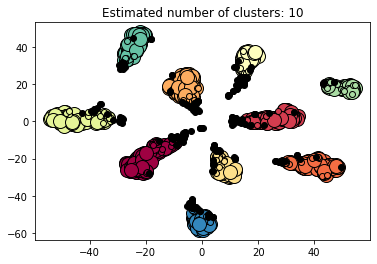

In [ ]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = dbscan.transform(train_X[:1000])[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = dbscan.transform(train_X[:1000])[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

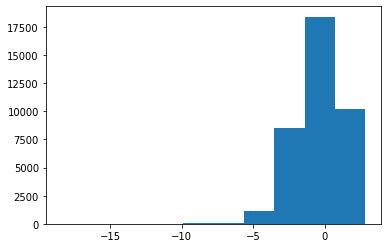

In [ ]:
plt.hist(np.log(train_y+1e-8));

In [94]:
results_dict = {'model':[] ,"r2":[], 'mae':[], 'mse':[], 'rmse':[]}

In [30]:
results_dict = dict(pd.read_csv("model_results.csv").drop('Unnamed: 0', axis=1))

### Dummy Regressor

In [95]:
dr = DummyRegressor()
dr_mean_r2 = np.mean(cross_val_score(dr, train_X, np.log(train_y+1e-8), scoring='r2', cv=5))
dr_mean_r2

-6.850658300106005e-05

In [96]:
dr.fit(train_X, train_y)
dr_pred = dr.predict(train_X)

In [97]:
r2_score(train_y, dr_pred)

0.0

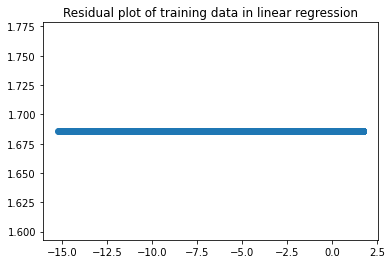

In [98]:
plt.scatter(dr_pred-test_y,dr_pred)
plt.title("Residual plot of training data in linear regression");

In [99]:
ret_metrics(dr, train_X, train_y)

(1.6237796242077158, 5.51870815281436, 2.349193085468787)

In [100]:
results_dict['model'].append(dr)
results_dict['r2'].append(r2_score(test_y, dr_pred))
a, s, rs = ret_metrics(dr, train_X, train_y)
results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

(None, None, None)

### Linear Regression

In [103]:
lr = LinearRegression()
lr_mean_r2 = np.mean(cross_val_score(lr, train_X, train_y, scoring='r2', cv=5))

In [104]:
lr.fit(train_X, train_y)
lr_pred = lr.predict(train_X)

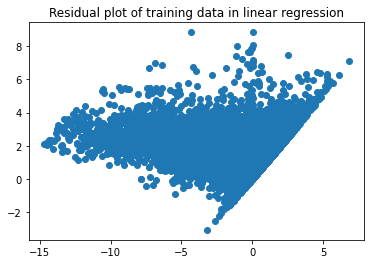

In [106]:
plt.scatter(lr_pred-train_y,lr_pred)
plt.title("Residual plot of training data in linear regression");

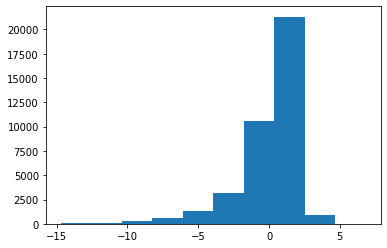

In [107]:
plt.hist(lr_pred-train_y);

In [108]:
r2_score(train_y, lr_pred), ret_metrics(lr, train_X, train_y)

(0.10326430225769367,
 (1.542724177296679, 4.948822606050139, 2.224594930779565))

In [109]:
results_dict['model'].append(lr)
results_dict['r2'].append(r2_score(test_y, lr.predict(train_X)))
a, s, rs = ret_metrics(lr, train_X, train_y)
results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

(None, None, None)

### SGD, ElasticNet

In [110]:
r = SGDRegressor()
r_mean_r2 = np.mean(cross_val_score(r, train_X, train_y, scoring='r2', cv=5))


In [111]:
r.fit(train_X, train_y)
r_pred = lr.predict(train_X)

In [112]:
r2_score(train_y, r_pred), ret_metrics(r, train_X, train_y)

(0.10326430225769367,
 (226918343306.83856, 6.444144957794253e+23, 802754318443.3362))

In [113]:
results_dict['model'].append(r)
results_dict['r2'].append(r2_score(test_y, r.predict(train_X)))
a, s, rs = ret_metrics(lr, train_X, train_y)
results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

(None, None, None)

We can see that with the usage of linear, SGD regression, the residual plot shows the presence of heteroscadasticity. Since this is one of the assumptions made by linear regression (residuals need to be homoscadastic) we can, as a result, understand the ability of the above algorithms to not perform any better.

In [ ]:
en = ElasticNet()
en_parameters = {'alpha':[0,1], 'selection':('cyclic', 'random'), 'l1_ratio':[0, 1, 0.2, 0.8, 0.5] } # accounts for regression with both OLS, l1, l2 regularization

en = model_train(en, en_parameters)
en.best_params_

{'alpha': 0, 'l1_ratio': 0, 'selection': 'cyclic'}

In [114]:
en = ElasticNet(alpha=0, l1_ratio=0, selection='cyclic')
en.fit(train_X, train_y)

ElasticNet(alpha=0, l1_ratio=0)

In [115]:
en_pred = en.predict(train_X)
ret_metrics(en, train_X, train_y)

(1.5689967959790043, 5.125500241183651, 2.263956766633067)

In [116]:
results_dict['model'].append(en)
results_dict['r2'].append(r2_score(test_y, en.predict(train_X)))
a, s, rs = ret_metrics(en, train_X, train_y)
results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

(None, None, None)

In [118]:
# pd.DataFrame(results_dict)

### Decision Trees
- They don't make the same assumption of homoscedasticity as linear regression models make.

In [ ]:
# dtr = DecisionTreeRegressor()
# dtr_parameters = {'criterion':["squared_error", "friedman_mse"], 'max_depth':[None, 10, 50, 100]} # accounts for regression with both OLS, l1, l2 regularization

# dtr = GridSearchCV(dtr, dtr_parameters) #defaults at cv value of 5 which we are okay with
# dtr.fit(train_X, train_y)
# dtr.best_params_

{'criterion': 'squared_error', 'max_depth': 10}

In [120]:
dtr = DecisionTreeRegressor(criterion='squared_error', max_depth=10)
dtr.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=10)

In [172]:
r2_score(train_y, dtr.predict(train_X))

0.05552611620193104

In [122]:
ret_metrics(dtr, train_X, train_y)

(1.3393554254283695, 3.9313973843047982, 1.9827751724047782)

In [123]:
dtr.predict(test_X)[:10], test_y[:10]

(array([1.22696864, 2.17318423, 1.49204481, 1.17801691, 1.0940195 ,
        1.8267042 , 1.0940195 , 0.54436106, 1.53477261, 1.53477261]),
 10791    0.127819
 37825    0.123120
 26950    0.145305
 27811    0.384494
 2581     1.270952
 23044    0.849514
 25132    0.563838
 40253    0.395396
 44323    0.346705
 21065    0.781136
 Name: score, dtype: float64)

In [124]:
results_dict['model'].append(dtr)
results_dict['r2'].append(r2_score(train_y, dtr.predict(train_X)))
a, s, rs = ret_metrics(dtr, train_X, train_y)
results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

(None, None, None)

In [126]:
# pd.DataFrame(results_dict)#.to_csv("model_results.csv")

,model,r2,mae,mse,rmse
0,DummyRegressor(),-5.662137e-14,1.623780,5.518708,2.349193
1,LinearRegression(),1.032643e-01,1.542724,4.948823,2.224595
2,SGDRegressor(),-1.167691e+23,1.542724,4.948823,2.224595
3,"ElasticNet(alpha=0, l1_ratio=0)",7.125004e-02,1.568997,5.125500,2.263957
4,DecisionTreeRegressor(max_depth=10),2.876236e-01,1.339355,3.931397,1.982775


In [130]:
np.argsort(-dtr.feature_importances_)[:10]

array([814,   4,  12, 877,  11,  63, 845,  10,   8, 870])

In [244]:
# results_dict

### Random Forest Regressor
- In an attempt to reduce the variance in the model.
- We're also moving towards blackbox models because, with the degree 15 interaction terms, we've lost a lot of interpretability already.
- We're also mindful of the parameters that showed promise for decision trees and hence we incfrementally carry the one's that did well to related models downstream.

Note:
- Grid search takes over 3hrs
- a custom run takes ~25mins

In [ ]:
# rfr = RandomForestRegressor()
# rfr_parameters = {'criterion':["squared_error"], 'max_depth':[10, 20], 'n_estimators':[10, 20, 50, 100, 120], 'oob_score':[True]} #default assumes bootsrapping so should be faster
# rfr = GridSearchCV(rfr, rfr_parameters, cv=3) #defaults at cv value of 5 which we are okay with
# rfr.fit(train_X, train_y)
# rfr.best_params_

In [201]:
rfr = RandomForestRegressor(criterion='squared_error', max_depth=10, n_estimators=50, oob_score=True)
rfr.fit(train_X, train_y)

RandomForestRegressor(max_depth=15, n_estimators=40, oob_score=True)

In [204]:
# ret_metrics(rfr, train_X, train_y)

(1.1253375178720963, 2.574815041961635, 1.604623021759826)

In [134]:
# results_dict['model'].append(rfr)
# results_dict['r2'].append(r2_score(train_y, rfr.predict(train_X)))
# a, s, rs = ret_metrics(rfr, train_X, train_y)
# results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

(None, None, None)

In [208]:
# results_dict

In [62]:
# pd.DataFrame(results_dict)

In [209]:
pd.DataFrame(results_dict).to_csv("model_results.csv", index=False)

Boosting Based Regressors

In [83]:
from sklearn.ensemble import GradientBoostingRegressor

In [84]:
# gbr = GradientBoostingRegressor()
# gbr_parameters = {'learning_rate':[0.05, 0.2, 0.5], 'subsample':[0.4], 'n_estimators':[10, 50], 'criterion':['squared_error']}
# grid_r = GridSearchCV(gbr, gbr_parameters, cv=3)
# grid_r.fit(train_X, train_y)
# grid_r.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.2,
 'n_estimators': 50,
 'subsample': 0.4}

In [183]:
# r2_score(test_y, grid_r.predict(train_X)),ret_metrics(grid_r, train_X, train_y)

In [210]:
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, subsample=0.6, criterion='squared_error')
gbr.fit(train_X, train_y)

GradientBoostingRegressor(subsample=0.6)

In [213]:
r2_score(train_y, gbr.predict(train_X))
ret_metrics(gbr, train_X, train_y)

(1.4983474088910396, 4.767138075398757, 2.1833776758496817)

In [72]:
results_dict['model'].append(gbr)
results_dict['r2'].append(r2_score(test_y, gbr.predict(train_X)))
a, s, rs = ret_metrics(gbr, train_X, train_y)
results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

In [ ]:
results_dict

In [73]:
pd.DataFrame(results_dict).to_csv("model_results.csv", index=False)

HistGradientBoostingRegressor (faster variant)

Note:
- Grid search takes over 1.5hrs

In [239]:
# hgbr = HistGradientBoostingRegressor(validation_fraction=0.2, n_iter_no_change=15)
# hgbr_parameters = {'max_iter':[80, 100, 120], 'max_leaf_nodes':[30, 50, 80, 100], 'l2_regularization':[0, 0.2], 'max_depth':[None, 10, 50]}
# grid_r = GridSearchCV(hgbr, hgbr_parameters, cv=3)
# grid_r.fit(train_X, train_y)
# grid_r.best_params_

{'l2_regularization': 0.2,
 'max_depth': 10,
 'max_iter': 100,
 'max_leaf_nodes': 50}

In [245]:
hgbr = HistGradientBoostingRegressor(max_iter=100, max_leaf_nodes=50,
                                     validation_fraction=0.2, n_iter_no_change=15,
                                     l2_regularization=0.2, max_depth=10)
hgbr.fit(train_X, train_y)

HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10,
                              max_leaf_nodes=50, n_iter_no_change=15,
                              validation_fraction=0.2)

In [246]:
r2_score(train_y, hgbr.predict(train_X))

0.3719669142771279

In [247]:
ret_metrics(hgbr, train_X, train_y)

(1.2783689507119138, 3.588058181865228, 1.8942170366315545)

In [248]:
results_dict['model'].append(hgbr)
results_dict['r2'].append(r2_score(train_y, hgbr.predict(train_X)))
a, s, rs = ret_metrics(hgbr, train_X, train_y)
results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

(None, None, None)

In [253]:
pd.DataFrame(results_dict).to_csv("model_results.csv", index=False)

SVR 

Note: Training the model training takes over 1.5hrs for higher degree polynomials. We observed that, even for lower degrees, the improvement in the metrics was only as good as the dummy regressor.

In [ ]:
# svr = SVR(C=1, kernel='poly', degree=5)
# svr.fit(train_X, train_y)

In [2]:
# r2_score(train_y, svr.predict(train_X))

In [256]:
# ret_metrics(svr, train_X, train_y)

(1.4983474088910396, 4.767138075398757, 2.1833776758496817)

In [ ]:
# results_dict['model'].append(svr)
# results_dict['r2'].append(r2_score(train_y, svr.predict(train_X)))
# a, s, rs = ret_metrics(svr, train_X, train_y)
# results_dict['mae'].append(a), results_dict['mse'].append(s), results_dict['rmse'].append(rs)

**####################This notebook ends here####################**

### Model Modeling Phase 2/2:
The purpose of the next notebook will be to:
- pick the top 3 best performing models across different families of algorithms.
- Compare the top 3 to their own default versions to document performance improvements.
- Identifying best/worst performing feature choices across all the chosen models.

- In the exploratory phase we saw that the variance captured by the first 10 PCA components was close to 80% which leads to the idea that the underlying data might be non-linear in nature.
- Our goal thus becomes to make help address this if we are making use of linear models like linear regression. 
- We will make use of polynomial features for the non-word-vector fields. 
- The next step to achieve the above goal would be to find the optimal number of polynomial features that help improve model results.

In [ ]:
# lr_pipeline = Pipeline([('create_dataset', FunctionTransformer(create_train_dataset)),
#           ('ohe', OneHotEncoder(handle_unknown='ignore')),
#           ('scale',MaxAbsScaler()),
#           ('lr', LinearRegression())]) 

In [ ]:
# lr_pipeline.fit(data_train, target)

In [ ]:
# filename = 'model.sav'
# pickle.dump(lr_pipeline, open(filename, 'wb'))

Streamlit code starts from here

In [ ]:
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model.score(data_test, test_target)

In [ ]:
# title = "love is in the air"
# duration = int("10000")
# publishedAt = datetime.datetime.now()
# definition = "hd"
# topicLabel = "Music"

In [ ]:
# featureset = ["title", "duration", "publishedAt", "definition", "topicLabel"]

In [ ]:
# user_ip = pd.DataFrame([[title, duration, publishedAt, definition, topicLabel]], columns=featureset)
# user_ip

In [ ]:
# loaded_model.predict(user_ip)[0]

user will input:
- title (needs more than 1conversion)
- duration_secs (needs conversion)
- publishedAt(convert to publishedDayNum
- len_title (use title)

In [ ]:
# df.columns

Index(['title', 'description', 'channelTitle', 'categoryId', 'viewCount',
       'avg_viewCount', 'likeCount', 'commentCount', 'duration_secs',
       'log_duration_secs', 'definition', 'topicCategories', 'publishedDayNum',
       'publishedDayDelta', 'len_title', 'topicLabel', 'score', 'channelName',
       'ov_viewCount', 'ov_subscriberCount', 'ov_videoCount'],
      dtype='object')

In [ ]:
import pickle
filename = 'en_model.sav'
pickle.dump(model, open(filename, 'wb'))